<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Recurrent Neural Networks (RNNs)

_Author: Riley Dallas (ATX)_

---


### Learning Objectives

- Learn how to train/test split for sequence data
- Use `TimeseriesGenerator` to prep our time series data for modeling
- Create a basic RNN model using `keras`

In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.8.0
Keras Version: 2.8.0

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Pandas 1.4.1
Scikit-Learn 1.0.2
GPU is NOT AVAILABLE


In [2]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt

## Load data: AAPL stock prices and SEC filings
---

There are two datasets that we'll merge together:
- Apple's historical stock prices (ticker: AAPL)
- Their SEC filings:
  - Annual earnings reports: 10-K
  - Quarterly earnings reports: 10-Q
  - Company news and updates: 8-K

Load both in the cells below.

In [3]:
prices = pd.read_csv('../datasets/AAPL.csv')
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
1,2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2,2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
3,2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
4,2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [4]:
filings = pd.read_csv('../datasets/filings.csv')
filings.head()

,Date,10-K,10-Q,8-K
0,1994-12-13,1.0,0.0,0.0
1,1995-12-19,1.0,0.0,0.0
2,1996-12-19,1.0,0.0,0.0
3,1997-12-05,1.0,0.0,0.0
4,1999-12-22,1.0,0.0,0.0


## `Date` columns
---

For both datasets, we need to:
1. Convert the `Date` column to be a `datetime` object
2. Since these are time series datasets, we need the indices to be the `Date` columns

In [5]:
prices['Date'] = pd.to_datetime(prices['Date'])

In [6]:
prices.set_index('Date', inplace=True)
prices.sort_index(inplace=True)

In [7]:
filings['Date'] = pd.to_datetime(filings['Date'])

In [8]:
filings.set_index('Date', inplace=True)
filings.sort_index(inplace=True)

## Data cleaning: Prices
---

For Apple's stock prices, we'll need to do a few things:
1. Drop the `Adj Close` column since we already have a `Close` price
2. De-trend the dataset using `.pct_change()`
3. Drop any `NaN`s that were created from step 2

In [9]:
prices.drop(columns='Adj Close', inplace=True)

<AxesSubplot:xlabel='Date'>

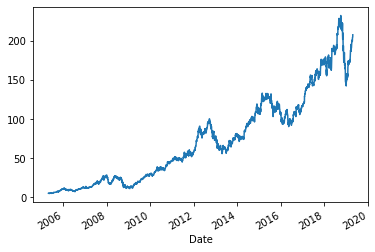

In [10]:
prices['Close'].plot()

In [11]:
prices = prices.pct_change()
prices.head()

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-25,NaN,NaN,NaN,NaN,NaN
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838


In [12]:
prices.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

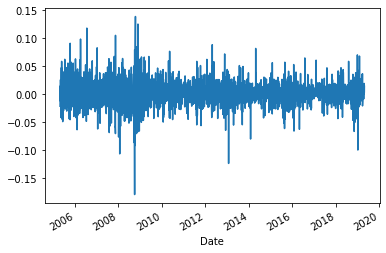

In [13]:
prices.Close.plot()

## Create `Target` column
---

Our column of interest is the `Close` prices. We could build a regression model, where we predict the actual percentage change, or we could set this up as a binary classification problem:
- 1: The `Close` price was greater than or equal to the previous day
- 0: The `Close` price was lower than the previous day

We'll go with the latter option. In the cell below, let's create our binary `Target` column.

In [14]:
prices['Target'] = (prices['Close'] > 0).astype(int)
prices.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1


## Merge Prices with SEC filings
---

SEC filings tend to have a huge impact on stock prices. Because of this, we'll want to merge the prices and filings `DataFrames` together.

**NOTE** We'll want to do a left join, so that we don't lose any rows that aren't associated with any SEC filings.

In [15]:
df = pd.merge(prices, filings, left_index=True, right_index=True, how='left')

## Fill `NaN`s
---

After the merge, we now have a bunch of `NaN`s for rows that didn't have any SEC filings on that date. Let's fill those in with 0.

In [16]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Target       0
10-K      3431
10-Q      3431
8-K       3431
dtype: int64

In [17]:
df.fillna(0, inplace=True)

In [18]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Target    0
10-K      0
10-Q      0
8-K       0
dtype: int64

## Train/Test Split
---

Since we're dealing with time series data, we don't want the model to be able to see the future. 

**When using `train_test_split` on time series date, set `shuffle=False` so that the order is maintained.**

In [19]:
features = [col for col in df.columns if not col == 'Target']
X = df[features]
y = df[['Target']].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
X_train.head()

,Open,High,Low,Close,Volume,10-K,10-Q,8-K
Date,,,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0.0,0.0,0.0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0.0,0.0,0.0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0.0,0.0,0.0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,0.0,0.0,0.0
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,0.0,0.0,0.0


## Scaling
---

You want to scale your data for any model that uses gradient descent, which includes neural networks.

In [21]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## `TimeseriesGenerator`
---

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [22]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)

In [23]:
batch_x, batch_y = train_sequences[0]

In [24]:
batch_x.shape

(64, 3, 8)

In [25]:
batch_y.shape

(64, 1)

In [26]:
batch_x[0]

array([[ 0.277762  ,  0.65593887, -0.05122123, -1.04709738,  0.0686483 ,
        -0.06165092, -0.10536889, -0.02752931],
       [-1.09289224, -1.76187057, -0.82999299, -0.36944379, -0.74627527,
        -0.06165092, -0.10536889, -0.02752931],
       [ 0.41411047, -0.10343687, -0.40875   , -0.58900501, -0.30105021,
        -0.06165092, -0.10536889, -0.02752931]])

In [27]:
pd.DataFrame(X_train_sc, columns=X_train.columns).head(3)

,Open,High,Low,Close,Volume,10-K,10-Q,8-K
0,0.277762,0.655939,-0.051221,-1.047097,0.068648,-0.061651,-0.105369,-0.027529
1,-1.092892,-1.761871,-0.829993,-0.369444,-0.746275,-0.061651,-0.105369,-0.027529
2,0.414110,-0.103437,-0.408750,-0.589005,-0.301050,-0.061651,-0.105369,-0.027529


In [28]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 2 hidden `Dense` layers
- 1 `Dense` output layer

We're doing a binary classification problem. As a result, our output layer needs to be 1 neuron, with the `sigmoid` activation function. This way, our model predicts a probability.

In [29]:
train_sequences[0][0].shape

# batch size is 64 
# length 3 
# 8 columns from the xtrain 

(64, 3, 8)

In [30]:
input_shape = train_sequences[0][0][0].shape
input_shape

(3, 8)

In [31]:
# need to put in the shape that takes 3,8 like shown in the notes 


In [32]:
model = Sequential()

# what is the number 
# 8 columns need to vacuum up all 

model.add(GRU(8, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN

# dont need to put in input_shape anymore 
model.add(GRU(8, return_sequences=False)) # False if next layer is Dense

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer=Adam(lr=.0005), loss='bce', metrics=['acc'])


# train squences will take in x and y train already
history = model.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


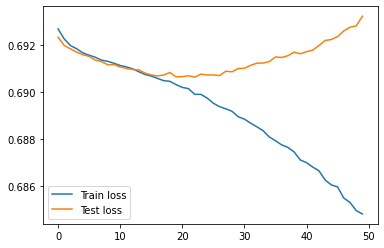

In [34]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();

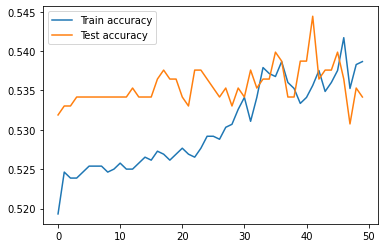

In [35]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend();

In [36]:
# Add early stopping
from tensorflow.keras.callbacks import EarlyStopping

model2 = Sequential()
model2.add(GRU(8, input_shape=(3, 8), return_sequences=True)) # True if next layer is RNN
model2.add(GRU(8, return_sequences=False)) # False if next layer is Dense

model2.add(Dense(4, activation='relu'))

model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='bce', metrics=['acc'])

es = EarlyStopping(patience = 5)

history2 = model2.fit(train_sequences, validation_data=test_sequences, epochs=100, callbacks = [es])

Epoch 1/100
42/42 [==============================] - 4s 19ms/step - loss: 0.6942 - acc: 0.5099 - val_loss: 0.6911 - val_acc: 0.5364
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6932 - acc: 0.5277 - val_loss: 0.6910 - val_acc: 0.5353
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6924 - acc: 0.5254 - val_loss: 0.6909 - val_acc: 0.5376
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.6920 - acc: 0.5250 - val_loss: 0.6908 - val_acc: 0.5330
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 0.6914 - acc: 0.5262 - val_loss: 0.6908 - val_acc: 0.5342
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6912 - acc: 0.5265 - val_loss: 0.6906 - val_acc: 0.5330
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6910 - acc: 0.5284 - val_loss: 0.6902 - val_acc: 0.5353
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6907 - 

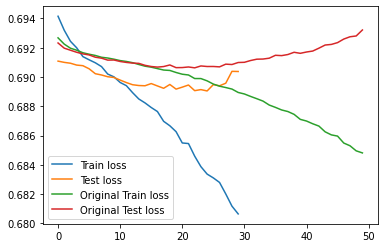

In [37]:
plt.plot(history2.history['loss'], label='Train loss')
plt.plot(history2.history['val_loss'], label='Test loss')
plt.plot(history.history['loss'], label='Original Train loss')
plt.plot(history.history['val_loss'], label='Original Test loss')
plt.legend();